# Homework 3
CSCI 5636  
Andrew Altomare

Here we solve the regularized $p$-Laplacian
$$ -\nabla\cdot (\kappa(\nabla u)\nabla u) = 0 $$
where
$$ \kappa(\nabla u) = \left(\frac{1}{2}\epsilon^2+\frac{1}{2}\nabla u\cdot\nabla u\right)^{\frac{p-2}{2}} $$

studying its response to variation in parameters $p, \epsilon$ and surveying a few different linear solvers in the process.

## Part 1

`picard_laplacian` below is an adaptation of `nonlinear2d_div` from lecture to accommodate $\kappa$, a function of $\nabla u$, and yield a Picard linearization. By default, we solve over the domain $\Omega = [0,1]\times [0,1]$ with Dirichlet conditions on the entire boundary $u|_{\Gamma_D} = 0$

Accommodating the new $\kappa$ is accomplished by expanding the stencil to 9 points and computing full gradients of $u$ at staggered points. There is an additional parameter `J_switch`, which returns only the residual, $F = -\nabla\cdot (\kappa(\nabla u)\nabla u) $, to avoid wasteful computation in the Newton-Krylov solver.

In [341]:
import numpy
import scipy.sparse as sp
import scipy.sparse.linalg
from matplotlib import pyplot

def hgrid(h):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    return x, y

def picard_laplacian(h, x, y, u, forcing, g0, params, dirichlet=((),()), J_switch=True):
    eps, p = params
    m = x.shape[0] # number of rows in grid
    u0 = g0(x, y).flatten() # value of u at boundary
    F = -forcing(x, y).flatten() 
    ai = []
    aj = []
    av = []
    def idx(i, j): # convert indices to 1D
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=bool) # mask domain and 0 out boundary, flatten
    mask[dirichlet[0],:] = False
    mask[:,dirichlet[1]] = False
    mask = mask.flatten()
    u = u.flatten()
    F[mask == False] = u[mask == False] - u0[mask == False]
    u[mask == False] = u0[mask == False]
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            # 9 point stencil
            stencili = numpy.array([idx(*pair) for pair in [(i-1,j-1), (i-1, j), (i-1, j+1), (i, j-1), (i, j), 
                                                            (i, j+1), (i+1,j-1), (i+1, j), (i+1, j+1)]])
            # Stencil to evaluate x components of gradients at staggered points
            gradx = numpy.array([[-0.25, 0, 0.25, -0.25, 0, 0.25, 0, 0, 0],
                                 [0, 0, 0, -1, 1, 0, 0, 0, 0],
                                 [0, 0, 0, 0, -1, 1, 0, 0, 0],
                                 [0, 0, 0, -0.25, 0, 0.25, -0.25, 0, 0.25]]) / h
            # Stencil to evaluate y components of gradients at staggered points
            grady = numpy.array([[0,-1, 0, 0, 1, 0, 0, 0, 0],
                                 [-0.25, -0.25, 0, 0, 0, 0, 0.25, 0.25, 0],
                                 [0, -0.25, -0.25, 0, 0, 0, 0, 0.25, 0.25],
                                 [0, 0, 0, 0, -1, 0, 0, 1, 0]]) / h
            # Stencil for evaluating gradients necessary for divergence
            grad = numpy.array([[0, -1, 0, 0, 1, 0, 0, 0, 0],
                                [0, 0, 0, -1, 1, 0, 0, 0, 0],
                                [0, 0, 0, 0, -1, 1, 0, 0, 0],
                                [0, 0, 0, 0, -1, 0, 0, 1, 0]]) / h
            # Stencil to compute divergence at cell centers from fluxes at four staggered points
            div = numpy.array([-1, -1, 1, 1]) / h
            ustencil = u[stencili]
            gradu = numpy.array([gradx @ ustencil, grady @ ustencil]).T
            mix_grad = numpy.array([gradu[0,1], gradu[1,0], gradu[2,0], gradu[3,1]])
            kappa = numpy.array([(0.5*eps**2 + 0.5*(gu @ gu))**((p-2)/2) for gu in gradu])
            if mask[row] == 0 and J_switch: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
            else:
                F[row] -= div @ (kappa * mix_grad)
                if J_switch:
                    Jstencil = -div @ (kappa[:,None] * grad) # build J
                    smask = mask[stencili]
                    ai += [row]*sum(smask)
                    aj += stencili[smask].tolist()
                    av += Jstencil[smask].tolist() # build sparse matrix J
    if J_switch:
        J = sp.csc_matrix((av, (ai, aj)), shape=(m*m,m*m))
    else:
        J = 0
    return F, J

Demonstrate one iteration of the solver on the usual Laplacian (i.e. set $p=2$)
$$ -\nabla\cdot (\nabla u) = 0 $$

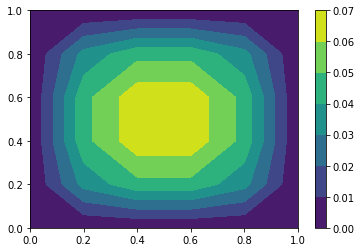

In [404]:
# u += deltau
h = .2
x, y = hgrid(h)
u = 0*x
params = (1,2) # solve a linear problem

F, J = picard_laplacian(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, params, dirichlet=((0,-1),(0,-1)))
deltau = sp.linalg.spsolve(J, -F).reshape(x.shape)
pyplot.contourf(x, y, deltau)
pyplot.colorbar();

Below is the `solve_nonlinear` function from lecture adapted to execute the Picard solver. The figure that follows is an illustration of convergence under a range of values of $p$. We see the rate of convergence get worse as $p$ grows. Notably, values below 2 all provide seemingly the same fast rate of convergence--these create negative exponents in $\kappa$.

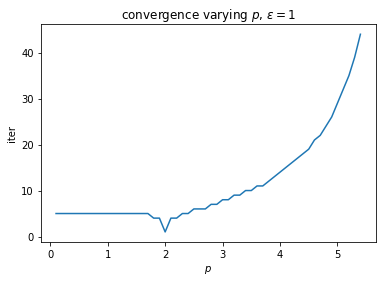

In [452]:
def solve_picard(h, g0, dirichlet, params, atol=1e-8, verbose=False):
    x, y = hgrid(h)
    u = 0*x
    norms = []
    for i in range(300):
        F, J = picard_laplacian(h, x, y, u, lambda x,y: 0*x+1,
                               g0=g0, params=params, dirichlet=dirichlet)
        anorm = numpy.linalg.norm(F, numpy.inf)
        norms += [anorm]
        if verbose:
            print('{:2d}: anorm {:8e}'.format(i,anorm))
        if anorm < atol:
            break
        deltau = sp.linalg.spsolve(J, -F)
        u += deltau.reshape(x.shape)
    return x, y, u, i, norms

ps = numpy.arange(.1,5.5,.1)
ii = []
for p in ps:
    params = (1,p)
    x, y, u, i,_ = solve_picard(h, lambda x,y: 0*x,
                             dirichlet=((0,-1),(0,-1)), params=params,
                             verbose=False)
    ii += [i]
pyplot.plot(ps, ii);
pyplot.xlabel('$p$');
pyplot.ylabel('iter');
pyplot.title('convergence varying $p$, $\epsilon = 1$');

## Part 2

Here we use the Picard linearization as a preconditioner to a Newton-Krylov method, which employs the GMRES linear solver. Using the residual, $F$, we approximate a matrix-free Jacobian with a finite differencing strategy.
$$ \tilde{J}(u)v \approx \frac{F(u+hv) - F(u)}{h} $$
Below `fsolve_newtonkrylov` has been adapted from lecture to include a preconditioner, which is a direct solve of the Picard linearization. To obtain the direct solve, we employ `splinalg.factorized`, which returns a callable LU decomposition. A run is shown with $\epsilon = 0.01$ and $p=4$. We see some stagnation at the beginning, some very slow linear convergence, and finally around the 22nd iteration some movement that appears to be quadratic.

No line search is used. Instead the step size is chosen to be 1 at each Newton iteration.

In [415]:
def fsolve_newtonkrylov(F, J, u0, epsilon=1e-8, rtol=1e-10, maxit=50, verbose=False):
    u = u0.copy()
    Fu = F(u)
    norm0 = numpy.linalg.norm(Fu)
    norms = []
    for i in range(maxit):
        def Ju_fd(v):
            return (F(u + epsilon*v) - Fu) / epsilon
        Ju = sp.linalg.LinearOperator((len(Fu),len(u)), matvec=Ju_fd)
        Pinv = sp.linalg.LinearOperator((len(Fu),len(u)), matvec=sp.linalg.factorized(J)) # preconditioner
        du, info = sp.linalg.gmres(Ju, Fu, atol=1.e-6, M=Pinv)
        if info != 0: # error handling
            print(numpy.linalg.norm(Ju @ du - Fu), norm)
            raise RuntimeError('GMRES failed to converge: {:d}'.format(info))
        u -= du # update u
        Fu = F(u)
        norm = numpy.linalg.norm(Fu)
        norms += [norm]
        if verbose:
            print('Newton {:d} anorm {:6.2e} rnorm {:6.2e}'
                  .format(i, norm, norm/norm0))
        if norm < rtol * norm0:
            break
    return u, i, norms

h = .2
x, y = hgrid(h)
u = (0*x).flatten()
params = (.01,4)

_, J = picard_laplacian(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, params, dirichlet=((0,-1),(0,-1)))
F = lambda u: picard_laplacian(h, x, y, u, lambda x,y: 0*x+1,
                       lambda x,y: 0*x, params, dirichlet=((0,-1),(0,-1)), J_switch=False)[0]

fsolve_newtonkrylov(F, J, u, rtol=1e-6, verbose=True);

Newton 0 anorm 1.76e+12 rnorm 4.39e+11
Newton 1 anorm 5.20e+11 rnorm 1.30e+11
Newton 2 anorm 1.54e+11 rnorm 3.85e+10
Newton 3 anorm 4.57e+10 rnorm 1.14e+10
Newton 4 anorm 1.35e+10 rnorm 3.38e+09
Newton 5 anorm 4.01e+09 rnorm 1.00e+09
Newton 6 anorm 1.19e+09 rnorm 2.97e+08
Newton 7 anorm 3.52e+08 rnorm 8.80e+07
Newton 8 anorm 1.04e+08 rnorm 2.61e+07
Newton 9 anorm 3.09e+07 rnorm 7.73e+06
Newton 10 anorm 9.16e+06 rnorm 2.29e+06
Newton 11 anorm 2.71e+06 rnorm 6.78e+05
Newton 12 anorm 8.04e+05 rnorm 2.01e+05
Newton 13 anorm 2.38e+05 rnorm 5.95e+04
Newton 14 anorm 7.06e+04 rnorm 1.76e+04
Newton 15 anorm 2.09e+04 rnorm 5.23e+03
Newton 16 anorm 6.19e+03 rnorm 1.55e+03
Newton 17 anorm 1.83e+03 rnorm 4.58e+02
Newton 18 anorm 5.41e+02 rnorm 1.35e+02
Newton 19 anorm 1.58e+02 rnorm 3.95e+01
Newton 20 anorm 4.45e+01 rnorm 1.11e+01
Newton 21 anorm 1.12e+01 rnorm 2.79e+00
Newton 22 anorm 1.90e+00 rnorm 4.74e-01
Newton 23 anorm 1.04e-01 rnorm 2.59e-02
Newton 24 anorm 3.84e-04 rnorm 9.60e-05
Newton 25 

### A comparison of Picard and Newton-Krylov solvers

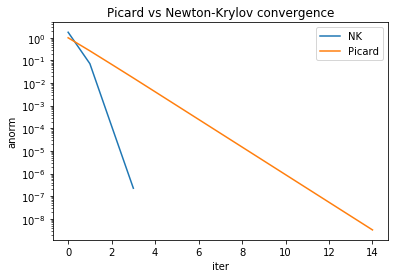

In [444]:
h = .2
x, y = hgrid(h)
u = (0*x).flatten()
params = (1,4)

_,i,norms = fsolve_newtonkrylov(F, J, u, rtol=1e-6, verbose=False);
_,_,_,j,norms2 = solve_picard(h, lambda x,y: 0*x,
                 dirichlet=((0,-1),(0,-1)), params=params,
                 verbose=False)

pyplot.title('Picard vs Newton-Krylov convergence')
pyplot.xlabel('iter')
pyplot.ylabel('anorm')
pyplot.semilogy(numpy.arange(i+1), norms, label='NK');
pyplot.semilogy(numpy.arange(j+1), norms2, label='Picard');
pyplot.legend();

## Part 3

To implement a Newton linearization, we need to construct the actual Jacobian of our residual. The Picard solver has $J_P = -\nabla\cdot(\kappa(\nabla u)\nabla\delta u)$. But the actual Jacobian is given by
$$\begin{align*}
J &= \partial F/\partial u \\
 &= \frac{\partial}{\partial u} \left(-\nabla\cdot (\kappa(\nabla u)\nabla u)\right) \\
 &= -\nabla\cdot \left(\frac{\partial}{\partial u}\kappa\nabla u + \kappa\frac{\partial}{\partial u}\nabla u\right) \\
 &= -\nabla\cdot \left(\frac{\partial}{\partial u}\kappa\nabla u + \kappa\nabla \delta u\right)
\end{align*}$$

The approximate matrix-free Jacobian that we constructed in KN is not only robust but also first order accurate in $\epsilon=10^{-9}$. It gives us the action of J on a vector, which is much easier to manipulate and saves memory costs as well. Implementing the Jacobian linearization would be convoluted and relatively expensive. Furthermore, since the matrix-free approximation is fairly accurate, I doubt our convergence would improve much in terms of number of iterations.